In [87]:
import numpy as np 
import pandas as pd 
from ase import Atoms
from ase import Atom
from ase.io import read
from ase.io import iread
from ase.io import write
from ase.io.trajectory import TrajectoryReader
import os
import statistics
import xcml
from ase.units import kB
T = 298.15 #K

In [88]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/gpfs/home/smdick/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['diff']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [164]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

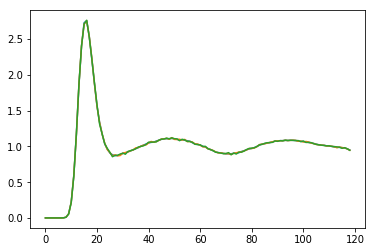

In [89]:
#Test convergence 
r_oo = pd.read_csv('/gpfs/scratch/smdick/mbpol/nose_128_10.bins', header = None)

figsize(6,4)
plot(r_oo.mean(axis=0))
plot(r_oo.loc[::10].mean(axis=0))
plot(r_oo.loc[::15].mean(axis=0));
# plot(r_oo.loc[::20].mean(axis=0))

In [95]:
r_oo_xyz = statistics.get_roo_xyz('/gpfs/home/smdick/exchange_ml/data/synced/datasets/128/128', 15.646,0,1,1)

e_mbpol = np.genfromtxt('/gpfs/home/smdick/exchange_ml/data/synced/processed_dz/clusters/128/energies.dat')
e_siesta = np.genfromtxt('/gpfs/home/smdick/exchange_ml/data/synced/processed_dz/clusters/128/energies_siesta.dat')

dV = np.tile((e_siesta - e_mbpol).reshape(-1,1),[1,r_oo_xyz.shape[1]])

network = xcml.load_network('/gpfs/home/smdick/exchange_ml/models/final/nn_mulliken_dz/')

M = np.genfromtxt('/gpfs/home/smdick/exchange_ml/data/synced/processed_dz/clusters/128/M_.dat', delimiter = ',')

corrections = xcml.use_model(M, 128, network, n_o_orb = 13, n_h_orb = 5)

dV_corr = np.tile(((e_siesta - corrections) - e_mbpol).reshape(-1,1),[1,r_oo_xyz.shape[1]])

delr_oo_corr = -1/(T*kB)*(np.mean(r_oo_xyz * dV_corr, axis = 0) - np.mean(r_oo_xyz, axis = 0)*np.mean(dV_corr,axis = 0))

delr_oo = -1/(T*kB)*(np.mean(r_oo_xyz * dV, axis = 0) - np.mean(r_oo_xyz, axis = 0)*np.mean(dV,axis = 0))

INFO:tensorflow:Restoring parameters from /gpfs/home/smdick/exchange_ml/models/final/nn_mulliken_dz/model.ckpt
Sharing scaler with species O
Sharing scaler with species H


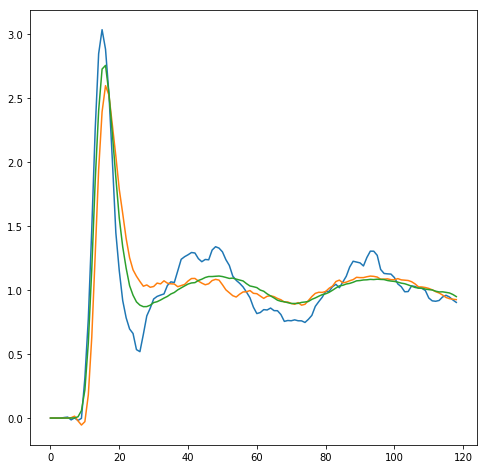

In [175]:
figsize(8,8)
# plot(r_oo.mean(axis=0))
# plot(r_oo.loc[::10].mean(axis=0))
# plot(r_oo.loc[::15].mean(axis=0))
# plot(np.mean(r_oo_xyz, axis =0) + delr_oo, marker = '.', ls = '')
# plot(np.mean(r_oo_xyz, axis =0) + delr_oo_corr, marker = '.', ls= '')
plot(savitzky_golay(np.mean(r_oo_xyz, axis =0) + delr_oo, 11, 5))
plot(savitzky_golay(np.mean(r_oo_xyz, axis =0) + delr_oo_corr, 15,6))
plot(r_oo.mean(axis=0))